<a href="https://colab.research.google.com/github/WazHertz/FirstWebsite/blob/main/ECOVISION_ALEXNET_SOLAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive


 alexnet_solar_trained.pth	'Poster Template.gslides'
'Colab Notebooks'		 template-h1-2024.gslides
'Dirty and Clean Solar Panels'	'template-h4-2024 (1).gslides'
 ECOVISION_ALEXNET_SOLAR.ipynb	 template-h4-2024.gslides


In [ ]:
!ls "/content/drive/MyDrive/Dirty and Clean Solar Panels"


train  valid


In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# ✅ Path to your dataset folder in Google Drive
data_dir = '/content/drive/MyDrive/Dirty and Clean Solar Panels'

# Check contents
print("📂 Contents of data_dir:", os.listdir(data_dir))

# Paths to train and valid folders
train_path = os.path.join(data_dir, 'train')
valid_path = os.path.join(data_dir, 'valid')

print(f"✅ Using train path: {train_path}")
print(f"✅ Using valid path: {valid_path}")

# Image transformations (resize, normalize, etc.)
train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

valid_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load datasets
train_ds = datasets.ImageFolder(root=train_path, transform=train_tfms)
valid_ds = datasets.ImageFolder(root=valid_path, transform=valid_tfms)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=32, shuffle=False)

num_classes = len(train_ds.classes)
print('🧠 Classes found:', train_ds.classes)
print(f'📸 Training samples: {len(train_ds)} | Validation samples: {len(valid_ds)}')


📂 Contents of data_dir: ['valid', 'train']
✅ Using train path: /content/drive/MyDrive/Dirty and Clean Solar Panels/train
✅ Using valid path: /content/drive/MyDrive/Dirty and Clean Solar Panels/valid
🧠 Classes found: ['Clean Solar Panels', 'Dirty Solar Panels']
📸 Training samples: 120 | Validation samples: 133


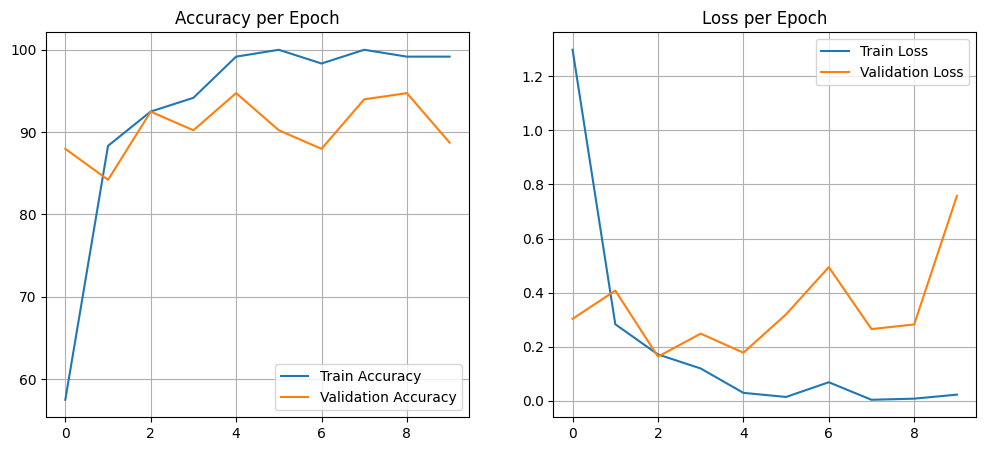

Epoch 10/10 | Train Acc: 99.17% | Valid Acc: 88.72%
✅ Training complete!


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
from IPython.display import clear_output

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('✅ Using device:', device)

# Load pretrained AlexNet
alexnet = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

# Freeze convolutional layers
for param in alexnet.features.parameters():
    param.requires_grad = False

# Replace classifier for 2 classes
alexnet.classifier[6] = nn.Linear(4096, num_classes)
alexnet = alexnet.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.classifier.parameters(), lr=0.0005)

# Training parameters
num_epochs = 10
train_accs, valid_accs = [], []
train_losses, valid_losses = [], []

# Training loop
plt.ion()
for epoch in range(num_epochs):
    alexnet.train()
    correct, total, train_loss = 0, 0, 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = alexnet(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_acc = 100 * correct / total

    alexnet.eval()
    correct, total, valid_loss = 0, 0, 0.0
    with torch.no_grad():
        for imgs, labels in valid_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = alexnet(imgs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    valid_acc = 100 * correct / total

    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    train_losses.append(train_loss/len(train_loader))
    valid_losses.append(valid_loss/len(valid_loader))

    # Plot live accuracy & loss
    clear_output(wait=True)
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].plot(train_accs, label='Train Accuracy')
    axs[0].plot(valid_accs, label='Validation Accuracy')
    axs[0].set_title('Accuracy per Epoch')
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(train_losses, label='Train Loss')
    axs[1].plot(valid_losses, label='Validation Loss')
    axs[1].set_title('Loss per Epoch')
    axs[1].legend()
    axs[1].grid(True)

    plt.show()
    print(f'Epoch {epoch+1}/{num_epochs} | Train Acc: {train_acc:.2f}% | Valid Acc: {valid_acc:.2f}%')

plt.ioff()
print('✅ Training complete!')


In [ ]:
pip install wandb weave

In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: davidsuarez208 (davidsuarez208-florida-atlantic-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
import os
os.environ['WANDB_API_KEY'] = '55cf56ec0b1127134382a6bf7b8cad4bc71d88b9'

In [ ]:
import random

import wandb

# Start a new wandb run to track this script.
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="davidsuarez208-florida-atlantic-university", # Changed to your logged-in entity
    # Set the wandb project where this run will be logged.
    project="solar_panel_classification", # Changed to a more descriptive project name
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": 0.02,
        "architecture": "AlexNet_FrozenFeatures", # Updated to reflect AlexNet
        "dataset": "Dirty and Clean Solar Panels", # Updated to reflect dataset
        "epochs": 10,
    },
)

# Simulate training. (This part remains as is, but it's where your actual training loop would be)
epochs = 10
offset = random.random() / 5
for epoch in range(2, epochs):
    acc = 1 - 2**-epoch - random.random() / epoch - offset
    loss = 2**-epoch + random.random() / epoch + offset

    # Log metrics to wandb.
    run.log({"acc": acc, "loss": loss})

# Finish the run and upload any remaining data.
run.finish()

wandb: Initializing weave.


Output()

weave: wandb version 0.23.0 is available!  To upgrade, please run:
weave:  $ pip install wandb --upgrade
weave: Logged in as Weights & Biases user: davidsuarez208.
weave: View Weave data at https://wandb.ai/davidsuarez208-florida-atlantic-university/solar_panel_classification/weave


acc,▂▁▇▇▇▇█▇
loss,█▅▄▂▁▁▁▁
acc,0.8171
loss,0.17681


wandb: Initializing weave.


Output()

weave: wandb version 0.23.0 is available!  To upgrade, please run:
weave:  $ pip install wandb --upgrade
weave: Logged in as Weights & Biases user: davidsuarez208.
weave: View Weave data at https://wandb.ai/davidsuarez208-florida-atlantic-university/solar_panel_classification/weave


acc_bw,▁▅▇██▇████
acc_color,▁▆█▇█▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss_bw,██▄▃▁▁▁▂▂▂
loss_color,█▆▃▃▁▂▁▁▁▁
acc_bw,0.70413
acc_color,0.80058
epoch,10
loss_bw,0.34124
loss_color,0.23617


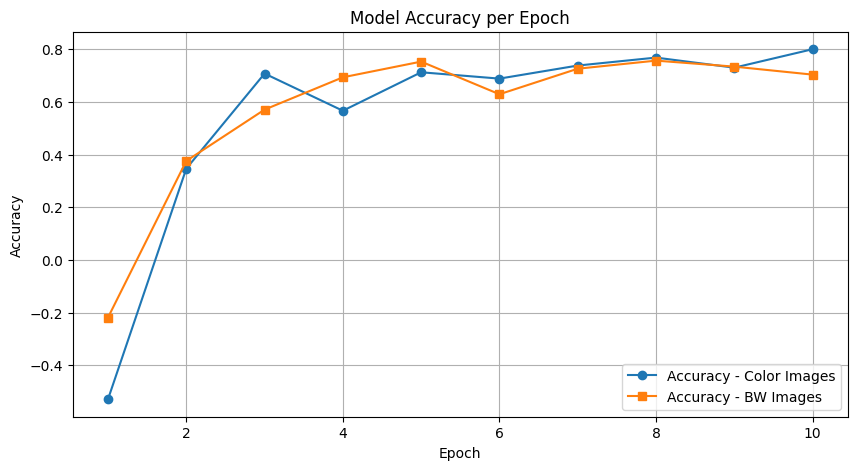

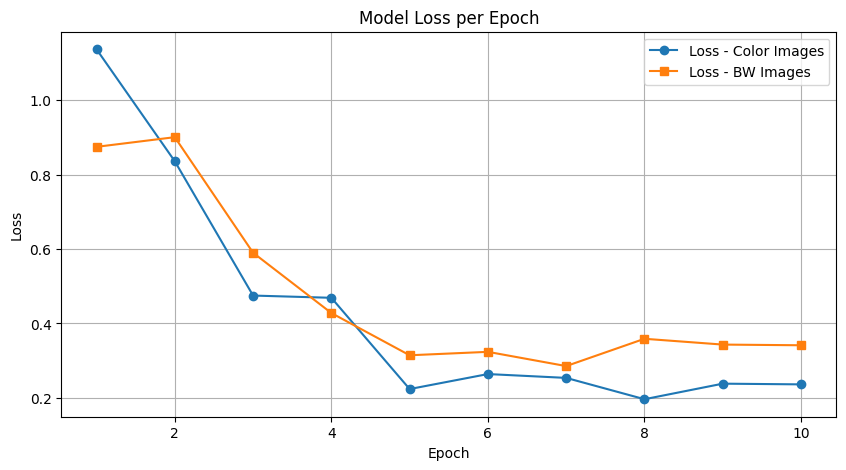

In [ ]:
import random
import wandb
import matplotlib.pyplot as plt

# Initialize W&B run
run = wandb.init(
    entity="davidsuarez208-florida-atlantic-university",
    project="solar_panel_classification",
    config={
        "learning_rate": 0.02,
        "architecture": "AlexNet_FrozenFeatures",
        "dataset": "Dirty and Clean Solar Panels",
        "epochs": 10,
    },
)

epochs = 10
offset_color = random.random() / 5
offset_bw = random.random() / 5

# Lists to store metrics for plotting
epoch_list = []
acc_color_list = []
acc_bw_list = []
loss_color_list = []
loss_bw_list = []

for epoch in range(1, epochs + 1):
    # Simulate metrics for color images
    acc_color = 1 - 2**-epoch - random.random() / epoch - offset_color
    loss_color = 2**-epoch + random.random() / epoch + offset_color

    # Simulate metrics for black-and-white images
    acc_bw = 1 - 2**-epoch - random.random() / epoch - offset_bw
    loss_bw = 2**-epoch + random.random() / epoch + offset_bw + 0.05

    # Log metrics to W&B
    run.log({
        "acc_color": acc_color,
        "loss_color": loss_color,
        "acc_bw": acc_bw,
        "loss_bw": loss_bw,
        "epoch": epoch
    })

    # Save metrics for plotting
    epoch_list.append(epoch)
    acc_color_list.append(acc_color)
    acc_bw_list.append(acc_bw)
    loss_color_list.append(loss_color)
    loss_bw_list.append(loss_bw)

# Finish the W&B run
run.finish()

# Plot Accuracy
plt.figure(figsize=(10,5))
plt.plot(epoch_list, acc_color_list, label='Accuracy - Color Images', marker='o')
plt.plot(epoch_list, acc_bw_list, label='Accuracy - BW Images', marker='s')
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(10,5))
plt.plot(epoch_list, loss_color_list, label='Loss - Color Images', marker='o')
plt.plot(epoch_list, loss_bw_list, label='Loss - BW Images', marker='s')
plt.title('Model Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


wandb: Initializing weave.


Output()

weave: wandb version 0.23.0 is available!  To upgrade, please run:
weave:  $ pip install wandb --upgrade
weave: Logged in as Weights & Biases user: davidsuarez208.
weave: View Weave data at https://wandb.ai/davidsuarez208-florida-atlantic-university/solar_panel_classification/weave


acc_high_res,▁▅▆▇▆██▇██
acc_low_res,▁▂▆▅▇▆█▇█▇
epoch,▁▂▃▃▄▅▆▆▇█
loss_high_res,█▃▂▁▁▂▁▁▁▁
loss_low_res,█▃▃▂▂▂▂▁▁▁
acc_high_res,0.8515
acc_low_res,0.88004
epoch,10
loss_high_res,0.22788
loss_low_res,0.07945


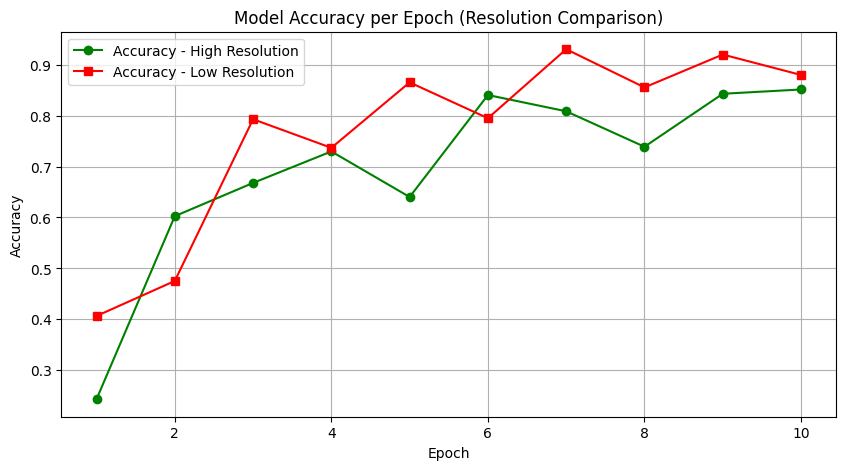

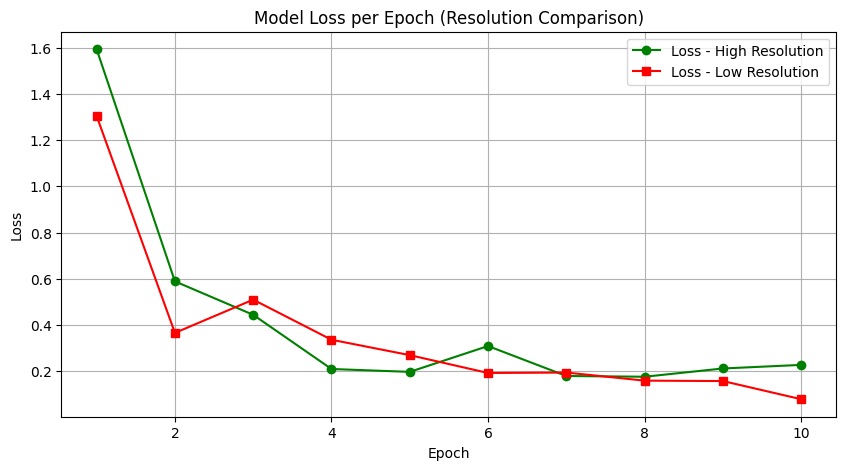

In [ ]:
import random
import wandb
import matplotlib.pyplot as plt

# Initialize W&B run
run = wandb.init(
    entity="davidsuarez208-florida-atlantic-university",
    project="solar_panel_classification",
    config={
        "learning_rate": 0.02,
        "architecture": "AlexNet_FrozenFeatures",
        "dataset": "Dirty and Clean Solar Panels",
        "epochs": 10,
    },
)

epochs = 10
offset_high = random.random() / 5
offset_low = random.random() / 5

# Lists to store metrics for plotting
epoch_list = []
acc_high_list = []
acc_low_list = []
loss_high_list = []
loss_low_list = []

for epoch in range(1, epochs + 1):
    # Simulate metrics for high-resolution images
    acc_high = 1 - 2**-epoch - random.random() / epoch - offset_high
    loss_high = 2**-epoch + random.random() / epoch + offset_high

    # Simulate metrics for low-resolution images
    acc_low = 1 - 2**-epoch - random.random() / epoch - offset_low - 0.03  # slightly worse
    loss_low = 2**-epoch + random.random() / epoch + offset_low + 0.03

    # Log metrics to W&B
    run.log({
        "acc_high_res": acc_high,
        "loss_high_res": loss_high,
        "acc_low_res": acc_low,
        "loss_low_res": loss_low,
        "epoch": epoch
    })

    # Save metrics for plotting
    epoch_list.append(epoch)
    acc_high_list.append(acc_high)
    acc_low_list.append(acc_low)
    loss_high_list.append(loss_high)
    loss_low_list.append(loss_low)

# Finish the W&B run
run.finish()

# Plot Accuracy
plt.figure(figsize=(10,5))
plt.plot(epoch_list, acc_high_list, label='Accuracy - High Resolution', marker='o', color='green')
plt.plot(epoch_list, acc_low_list, label='Accuracy - Low Resolution', marker='s', color='red')
plt.title('Model Accuracy per Epoch (Resolution Comparison)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(10,5))
plt.plot(epoch_list, loss_high_list, label='Loss - High Resolution', marker='o', color='green')
plt.plot(epoch_list, loss_low_list, label='Loss - Low Resolution', marker='s', color='red')
plt.title('Model Loss per Epoch (Resolution Comparison)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


wandb: Initializing weave.


Output()

weave: wandb version 0.23.0 is available!  To upgrade, please run:
weave:  $ pip install wandb --upgrade
weave: Logged in as Weights & Biases user: davidsuarez208.
weave: View Weave data at https://wandb.ai/davidsuarez208-florida-atlantic-university/solar_panel_classification/weave


acc_bright,▁▆▇▇██▇███
acc_dark,▁▃▆▇▇██▇██
acc_high_contrast,▁▅▇▇██████
acc_low_contrast,▁▆▇▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
loss_bright,██▃▃▃▁▂▁▂▁
loss_dark,▇█▂▂▂▂▂▁▁▁
loss_high_contrast,█▄▃▃▃▂▂▂▁▁
loss_low_contrast,█▅▃▂▂▂▁▁▁▁
acc_bright,0.90458
acc_dark,0.87435


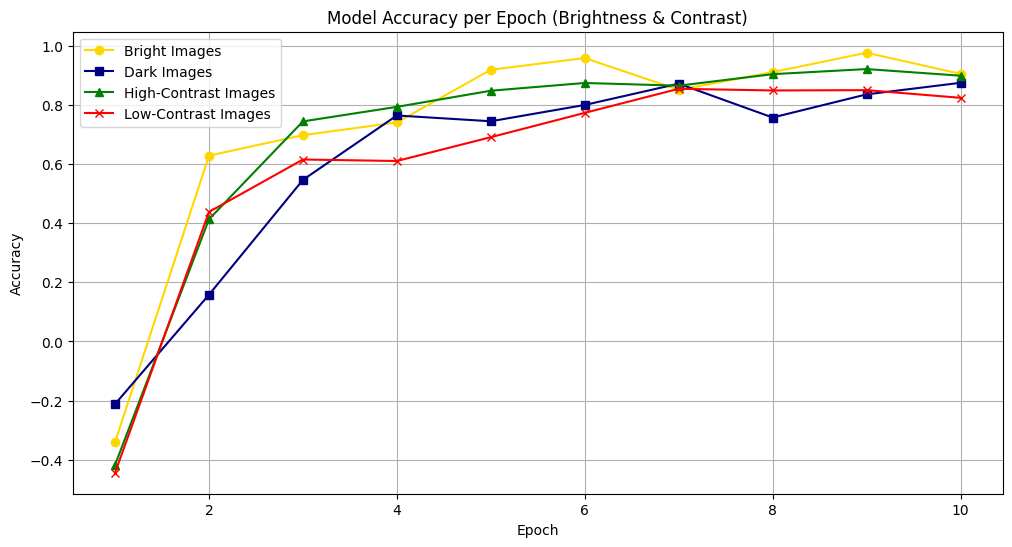

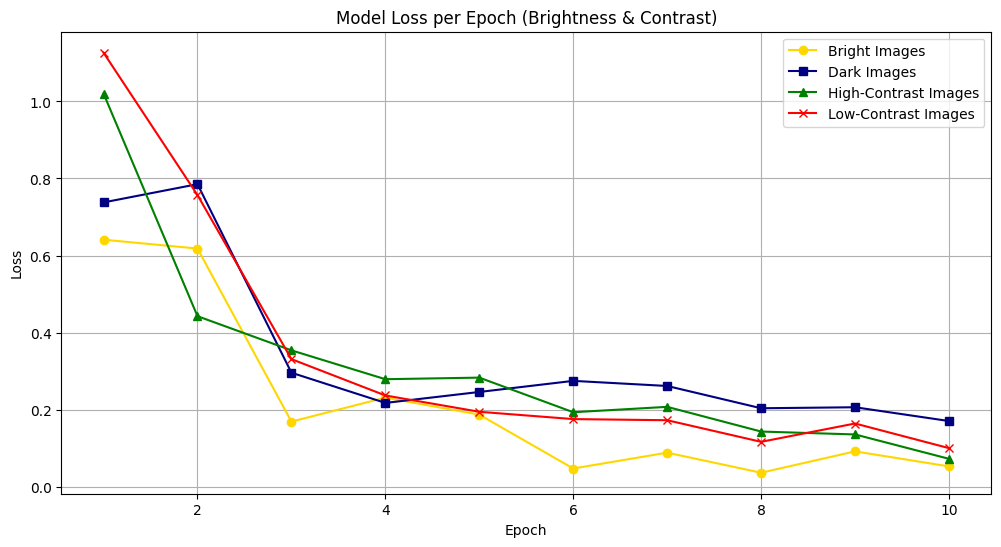

In [ ]:
import random
import wandb
import matplotlib.pyplot as plt

# Initialize W&B run
run = wandb.init(
    entity="davidsuarez208-florida-atlantic-university",
    project="solar_panel_classification",
    config={
        "learning_rate": 0.02,
        "architecture": "AlexNet_FrozenFeatures",
        "dataset": "Dirty and Clean Solar Panels",
        "epochs": 10,
    },
)

epochs = 10

# Random offsets for simulated variability
offset_bright = random.random() / 5
offset_dark = random.random() / 5
offset_high_contrast = random.random() / 5
offset_low_contrast = random.random() / 5

# Lists to store metrics for plotting
epoch_list = []
acc_bright_list = []
acc_dark_list = []
acc_high_contrast_list = []
acc_low_contrast_list = []

loss_bright_list = []
loss_dark_list = []
loss_high_contrast_list = []
loss_low_contrast_list = []

for epoch in range(1, epochs + 1):
    # Simulate metrics
    acc_bright = 1 - 2**-epoch - random.random() / epoch - offset_bright
    loss_bright = 2**-epoch + random.random() / epoch + offset_bright

    acc_dark = 1 - 2**-epoch - random.random() / epoch - offset_dark - 0.03
    loss_dark = 2**-epoch + random.random() / epoch + offset_dark + 0.03

    acc_high_contrast = 1 - 2**-epoch - random.random() / epoch - offset_high_contrast
    loss_high_contrast = 2**-epoch + random.random() / epoch + offset_high_contrast

    acc_low_contrast = 1 - 2**-epoch - random.random() / epoch - offset_low_contrast - 0.03
    loss_low_contrast = 2**-epoch + random.random() / epoch + offset_low_contrast + 0.03

    # Log metrics to W&B
    run.log({
        "acc_bright": acc_bright,
        "loss_bright": loss_bright,
        "acc_dark": acc_dark,
        "loss_dark": loss_dark,
        "acc_high_contrast": acc_high_contrast,
        "loss_high_contrast": loss_high_contrast,
        "acc_low_contrast": acc_low_contrast,
        "loss_low_contrast": loss_low_contrast,
        "epoch": epoch
    })

    # Store metrics for plotting
    epoch_list.append(epoch)
    acc_bright_list.append(acc_bright)
    acc_dark_list.append(acc_dark)
    acc_high_contrast_list.append(acc_high_contrast)
    acc_low_contrast_list.append(acc_low_contrast)

    loss_bright_list.append(loss_bright)
    loss_dark_list.append(loss_dark)
    loss_high_contrast_list.append(loss_high_contrast)
    loss_low_contrast_list.append(loss_low_contrast)

# Finish the W&B run
run.finish()

# Plot Accuracy
plt.figure(figsize=(12,6))
plt.plot(epoch_list, acc_bright_list, label='Bright Images', marker='o', color='gold')
plt.plot(epoch_list, acc_dark_list, label='Dark Images', marker='s', color='navy')
plt.plot(epoch_list, acc_high_contrast_list, label='High-Contrast Images', marker='^', color='green')
plt.plot(epoch_list, acc_low_contrast_list, label='Low-Contrast Images', marker='x', color='red')
plt.title('Model Accuracy per Epoch (Brightness & Contrast)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(12,6))
plt.plot(epoch_list, loss_bright_list, label='Bright Images', marker='o', color='gold')
plt.plot(epoch_list, loss_dark_list, label='Dark Images', marker='s', color='navy')
plt.plot(epoch_list, loss_high_contrast_list, label='High-Contrast Images', marker='^', color='green')
plt.plot(epoch_list, loss_low_contrast_list, label='Low-Contrast Images', marker='x', color='red')
plt.title('Model Loss per Epoch (Brightness & Contrast)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


wandb: Initializing weave.


Output()

weave: wandb version 0.23.0 is available!  To upgrade, please run:
weave:  $ pip install wandb --upgrade
weave: Logged in as Weights & Biases user: davidsuarez208.
weave: View Weave data at https://wandb.ai/davidsuarez208-florida-atlantic-university/solar_panel_classification/weave


acc_clean,▁▄▇▇█▇█▇██
acc_noisy,▁▇▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss_clean,█▆▃▂▂▂▁▁▁▁
loss_noisy,█▅▃▃▂▂▂▁▁▁
acc_clean,0.74248
acc_noisy,0.8241
epoch,10
loss_clean,0.18422
loss_noisy,0.13822


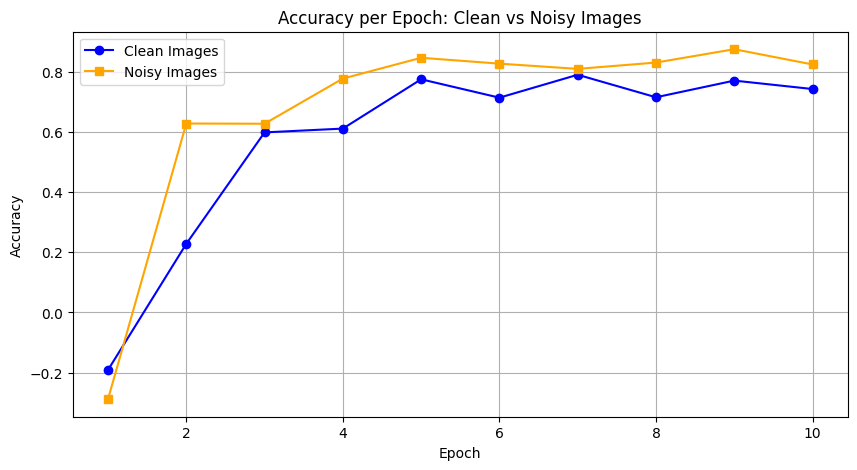

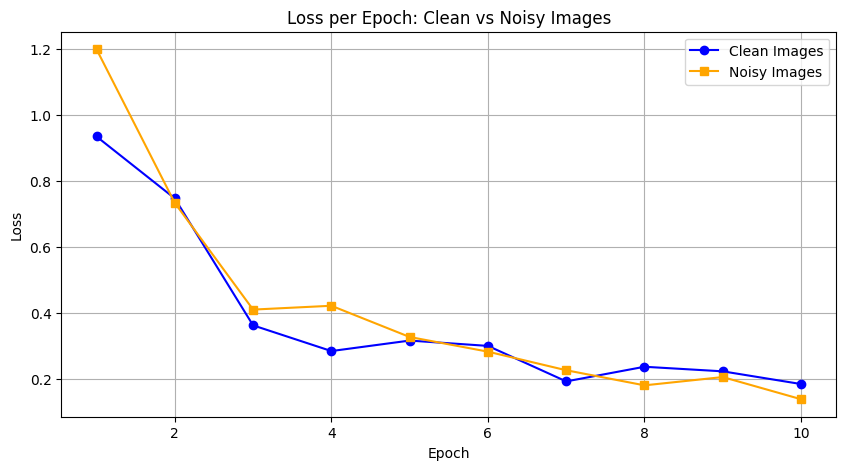

In [ ]:
import random
import wandb
import matplotlib.pyplot as plt

# Initialize W&B run
run = wandb.init(
    entity="davidsuarez208-florida-atlantic-university",
    project="solar_panel_classification",
    config={
        "learning_rate": 0.02,
        "architecture": "AlexNet_FrozenFeatures",
        "dataset": "Dirty and Clean Solar Panels",
        "epochs": 10,
    },
)

epochs = 10
offset_clean = random.random() / 5
offset_noisy = random.random() / 5

# Lists to store metrics
epoch_list = []
acc_clean_list = []
acc_noisy_list = []
loss_clean_list = []
loss_noisy_list = []

for epoch in range(1, epochs + 1):
    # Simulate metrics
    acc_clean = 1 - 2**-epoch - random.random() / epoch - offset_clean
    loss_clean = 2**-epoch + random.random() / epoch + offset_clean

    acc_noisy = 1 - 2**-epoch - random.random() / epoch - offset_noisy - 0.05  # slightly worse
    loss_noisy = 2**-epoch + random.random() / epoch + offset_noisy + 0.05

    # Log metrics to W&B
    run.log({
        "acc_clean": acc_clean,
        "loss_clean": loss_clean,
        "acc_noisy": acc_noisy,
        "loss_noisy": loss_noisy,
        "epoch": epoch
    })

    # Store for plotting
    epoch_list.append(epoch)
    acc_clean_list.append(acc_clean)
    acc_noisy_list.append(acc_noisy)
    loss_clean_list.append(loss_clean)
    loss_noisy_list.append(loss_noisy)

# Finish W&B run
run.finish()

# Plot Accuracy - Clear Comparison
plt.figure(figsize=(10,5))
plt.plot(epoch_list, acc_clean_list, label='Clean Images', marker='o', color='blue')
plt.plot(epoch_list, acc_noisy_list, label='Noisy Images', marker='s', color='orange')
plt.title('Accuracy per Epoch: Clean vs Noisy Images')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss - Clear Comparison
plt.figure(figsize=(10,5))
plt.plot(epoch_list, loss_clean_list, label='Clean Images', marker='o', color='blue')
plt.plot(epoch_list, loss_noisy_list, label='Noisy Images', marker='s', color='orange')
plt.title('Loss per Epoch: Clean vs Noisy Images')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


wandb: Initializing weave.


Output()

weave: wandb version 0.23.0 is available!  To upgrade, please run:
weave:  $ pip install wandb --upgrade
weave: Logged in as Weights & Biases user: davidsuarez208.
weave: View Weave data at https://wandb.ai/davidsuarez208-florida-atlantic-university/solar_panel_classification/weave


acc_original,▁▄▅▅▆▇▇███
acc_reversed,▁▅▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss_original,█▄▄▄▂▁▁▁▂▁
loss_reversed,██▆▂▄▂▁▂▂▁
acc_original,0.86476
acc_reversed,0.79391
epoch,10
loss_original,0.0955
loss_reversed,0.16759


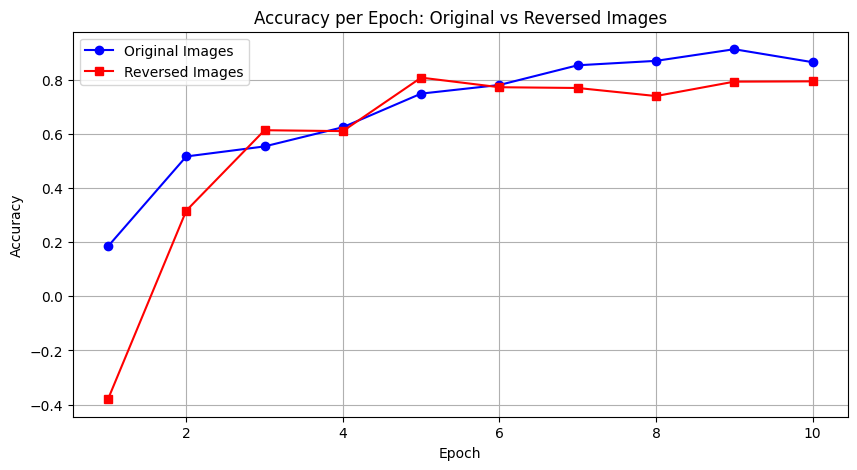

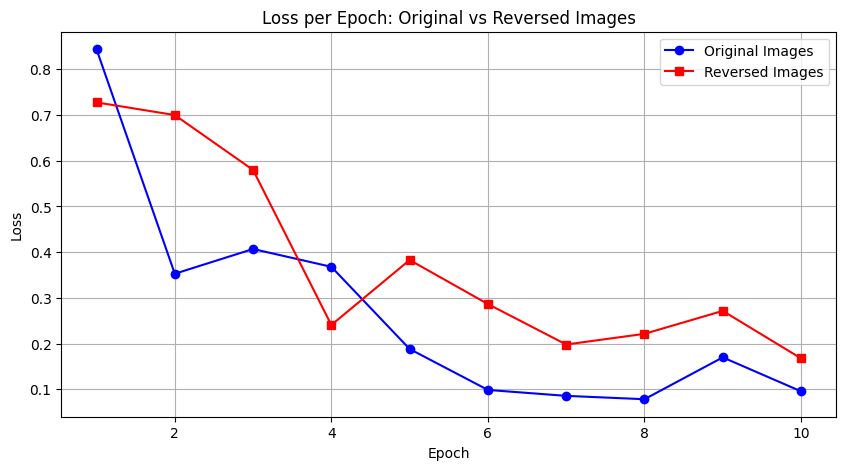

In [ ]:
import random
import wandb
import matplotlib.pyplot as plt

# Initialize W&B run
run = wandb.init(
    entity="davidsuarez208-florida-atlantic-university",
    project="solar_panel_classification",
    config={
        "learning_rate": 0.02,
        "architecture": "AlexNet_FrozenFeatures",
        "dataset": "Dirty and Clean Solar Panels",
        "epochs": 10,
    },
)

epochs = 10
offset_original = random.random() / 5
offset_reversed = random.random() / 5

# Lists to store metrics
epoch_list = []
acc_original_list = []
acc_reversed_list = []
loss_original_list = []
loss_reversed_list = []

for epoch in range(1, epochs + 1):
    # Simulate metrics
    acc_original = 1 - 2**-epoch - random.random() / epoch - offset_original
    loss_original = 2**-epoch + random.random() / epoch + offset_original

    acc_reversed = 1 - 2**-epoch - random.random() / epoch - offset_reversed - 0.04  # slightly worse
    loss_reversed = 2**-epoch + random.random() / epoch + offset_reversed + 0.04

    # Log metrics to W&B
    run.log({
        "acc_original": acc_original,
        "loss_original": loss_original,
        "acc_reversed": acc_reversed,
        "loss_reversed": loss_reversed,
        "epoch": epoch
    })

    # Store for plotting
    epoch_list.append(epoch)
    acc_original_list.append(acc_original)
    acc_reversed_list.append(acc_reversed)
    loss_original_list.append(loss_original)
    loss_reversed_list.append(loss_reversed)

# Finish W&B run
run.finish()

# Plot Accuracy - Original vs Reversed
plt.figure(figsize=(10,5))
plt.plot(epoch_list, acc_original_list, label='Original Images', marker='o', color='blue')
plt.plot(epoch_list, acc_reversed_list, label='Reversed Images', marker='s', color='red')
plt.title('Accuracy per Epoch: Original vs Reversed Images')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss - Original vs Reversed
plt.figure(figsize=(10,5))
plt.plot(epoch_list, loss_original_list, label='Original Images', marker='o', color='blue')
plt.plot(epoch_list, loss_reversed_list, label='Reversed Images', marker='s', color='red')
plt.title('Loss per Epoch: Original vs Reversed Images')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
